In [4]:
# Test script for classification
# Import packages

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
import numpy as np
import pandas as pd
import os
import sys
import importlib

# Good idea to add this folder to the json.settings file as "python.analysis.extraPaths".
sys.path.append('../functionScripts/')

import plotFunctions # totalCountsPlot, data_heatmap, correlation_plot
import analysisFunctions
import initFunctions as initf #import createDirs, debugReport, loadLightSheetData
import classifyFunctions
import helperFunctions

importlib.reload(initf)

# Set Paths to data and output
dirDict = dict()
rootDir = 'C:\OneDrive\KwanLab\Lightsheet_cFos_Pipeline\\'
dirDict['atlasDir'] = rootDir + 'Atlas\\'
dirDict['dataDir'] = rootDir + 'Data\\'
dirDict['B1'] =       dirDict['dataDir'] + 'lightSheetV1\\'
dirDict['B2'] =       dirDict['dataDir'] + 'lightSheetV2Rev\\'   #3/6/23 - Looking at the new, Realigned batch 2 data. #Realigned
dirDict['B2_Orig'] =  dirDict['dataDir'] + 'lightSheetV2\\'
dirDict['B3'] =       dirDict['dataDir'] + 'lightSheetV3\\'      #3/6/23 - Batch 3 with MDMA

batchSplit = False          # Splits drugs from the first batch of data, from the second, from the 3rd. Batch 1 is labeled with 'a' (aSAL, aKET, aPSI), Batch 3 (cKET, MDMA)
splitTag  = ['a', '', 'c']  # Appended the to beginning of data from the first batch (PSI, KET, SAL -> aPSI, KET, aSAL).
testSplit = False           # Splits an individual drug for the sake of examining self-similarity
oldBatch2 = False

debugOutputs = False        # Saves csvs at intervals
scalingFactor = True        # Applies 1/total_cells as a scaling factor per mouse.
debug_ROI = ['Dorsal nucleus raphe']
outputFormat = 'png'

switchDir = dict(testSplit=testSplit, batchSplit=batchSplit, splitTag=splitTag, oldBatch2=oldBatch2, debugOutputs=debugOutputs, scalingFactor=scalingFactor, debug_ROI=debug_ROI, outputFormat=outputFormat)

# Make directories, and add their strings to the directory dictionary.
dirDict = initf.createDirs(rootDir, switchDir, dirDict)

In [5]:
# Reload in case anything updated in these functions
importlib.reload(classifyFunctions)
importlib.reload(plotFunctions)
importlib.reload(helperFunctions)

# Set a random seed for reproducibility.
np.random.seed(seed = 31415)

classifyDict = dict()

# Parameters for pivoting the data
classifyDict['data'] = 'count_norm' #cell_density, count, count_norm, density_norm
classifyDict['feature'] = 'abbreviation'
classifyDict['label'] = 'drug' #'drug', 'class_5HT2A', 'class_KetPsi', 'class_5HTR', 'class_Trypt', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI'

# Parameters for feature scaling and aggregation
classifyDict['featurefilt'] = False
classifyDict['featureAgg'] = False
classifyDict['featureSel_linkage'] = 'average'  # 'average', 'complete', 'single', 'ward' (if euclidean)
classifyDict['featureSel_distance'] = 'correlation' # 'correlation, 'cosine', 'euclidean'
classifyDict['cluster_count'] = 100 # Number of clusters to generate. Not used at the moment.
classifyDict['cluster_thres'] = 0.2 # Anything closer than this is merged into a cluster
 
# Parameters for Preprocessing and feature selection
classifyDict['model_featureTransform'] = True # True, False - applies the Yeo-Johnson power transformation to shift features into more gaussian distributions.
classifyDict['model_featureScale'] = True # True, False
classifyDict['model_featureSel'] = 'Boruta' # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'
classifyDict['model_featureSel_alpha'] = 0.05 # Used for Fdr, Fwe, and Fwe_BH

# If Fdr/Fwe/None are not used for feature selection, the number of k feature must be preset
classifyDict['model_featureSel_mode'] = 'modelPer' # 'gridCV', 'modelPer'
# classifyDict['model_featureSel_k'] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
classifyDict['model_featureSel_k'] = [30]

# Parameters for classification
classifyDict['model'] = 'LogRegL2' #'LogRegL2', 'LogRegL1', 'ElasticNet', 'LDA', 'RandomForest'
classifyDict['multiclass'] = 'multinomial' # 'ovr', 'multinomial'
classifyDict['max_iter'] = 100
classifyDict['CVstrat'] = 'ShuffleSplit' #'StratKFold', 'ShuffleSplit'

# ParamGrid Features - in instances where gridCV is set to true, these are the parameters that will be tested.
paramGrid = dict()
paramGrid['classif__l1_ratio'] = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]          # used for ElasticNet
# paramGrid['classif__C'] = [0.001, 0.01, 0.1, 1, 10]                    # used for LogisticRegression
paramGrid['classif__C'] = [1]                    # used for LogisticRegression
classifyDict['pGrid'] = paramGrid

classifyDict['shuffle'] = False
classifyDict['gridCV'] = False

if classifyDict['CVstrat'] == 'ShuffleSplit':
    classifyDict['CV_count'] = 100 # Number of folds for cross-validation
else:
    # K fold stratified can only afford n_classes of folds
    classifyDict['CV_count'] = 8 

if classifyDict['label'] == 'drug':
    classifyDict['test_size'] = 1/8
    classifyDict['innerFold'] = 7
else:
    classifyDict['test_size'] = 1/4
    classifyDict['innerFold'] = 4

classifyDict['saveLoadswitch'] = True
dirDict['uniqID'] = 'try100'

# Load Pickle
lightsheet_data = pd.read_pickle('lightsheet_data.pkl')
lightsheet_data.loc[:, 'count_norm'] = lightsheet_data.loc[:, 'count']/lightsheet_data.loc[:, 'total_cells']
lightsheet_data.loc[:, 'density_norm'] = lightsheet_data.loc[:, 'count_norm']/lightsheet_data.loc[:, 'volume_(mm^3)']

lightsheet_data = lightsheet_data.fillna(0)

# Big Data - the dataset prior to filtering based on summary structures
# lightsheet_data = pd.read_pickle('lightsheet_data_big.pkl')
# lightsheet_data.rename(columns={'Brain Area': 'Brain_Area'}, inplace=True)

# Pure visualizations

# lightsheet_data_filt = helperFunctions.filter_features(lightsheet_data, classifyDict)
# plotFunctions.histPrePostScale(lightsheet_data, ['count', 'count_norm'], dirDict)
# plotFunctions.data_heatmap(lightsheet_data, 'abbreviation', 'cell_density', dirDict)
# plotFunctions.data_heatmap_single(lightsheet_data, 'abbreviation', 'cell_density', dirDict)

# Statistics
# lightsheet_data_filt = helperFunctions.filter_features(lightsheet_data, classifyDict)

# classifyDict['dimRed'] = 'SVC'
# plotFunctions.dim_red_plot(lightsheet_data_filt, classifyDict, dirDict)

# plotFunctions.distance_matrix(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot_hier(lightsheet_data, classifyDict, dirDict)

# valRange = np.arange(1,9)
# grids = np.meshgrid(valRange, valRange, valRange, valRange, valRange, valRange, valRange, valRange)
# combinations = np.column_stack([grid.flatten() for grid in grids])
# classifyFunctions.bootstrap_fstat(lightsheet_data, classifyDict, dirDict)

# classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)

Classifying class_PsiSSRI
evaluating model: PowerTransformer(standardize=False) -> RobustScaler() -> BorutaFeatureSelector() -> LogisticRegression(multi_class='multinomial', solver='saga')
Performing CV split 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

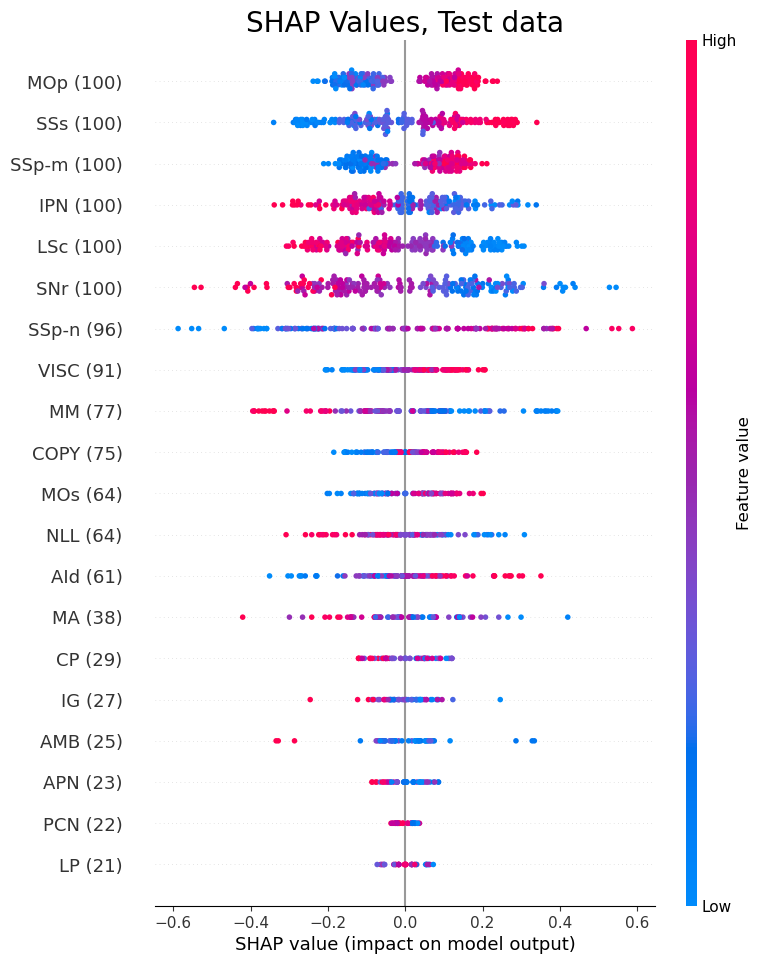

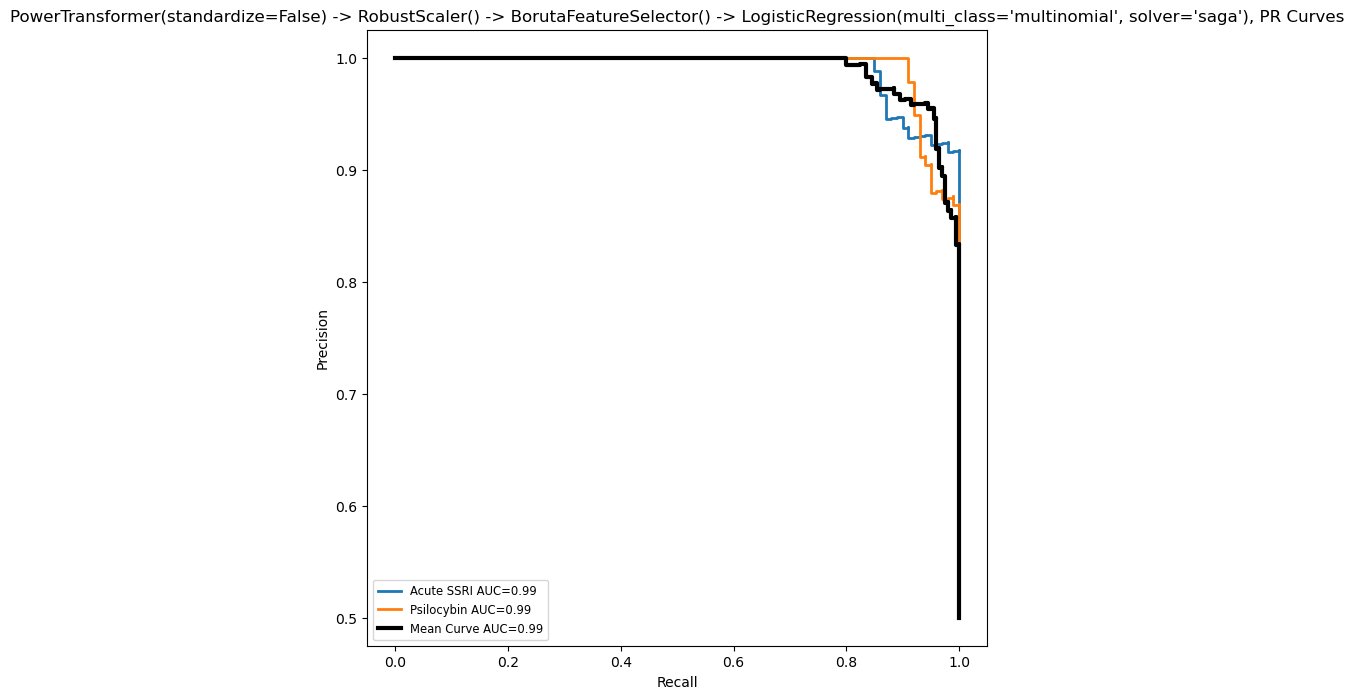

Real: 0.95 accuracy with a standard deviation of 0.14


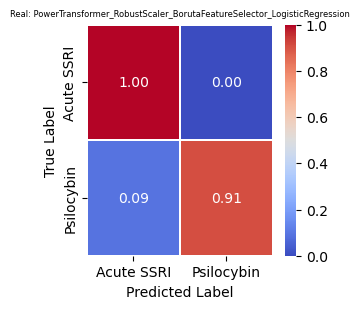

==== Acute SSRI vs Psilocybin ==== 
 Features per Model: [16, 19, 20, 18, 21, 17, 19, 15, 17, 17, 14, 11, 15, 13, 21, 11, 17, 13, 17, 16, 15, 18, 21, 14, 14, 15, 15, 15, 17, 23, 18, 17, 12, 19, 16, 17, 10, 13, 12, 23, 13, 14, 12, 16, 18, 15, 11, 10, 14, 13, 20, 18, 21, 18, 13, 17, 15, 13, 18, 12, 18, 17, 17, 13, 10, 14, 18, 20, 20, 17, 12, 16, 21, 18, 15, 20, 16, 15, 16, 16, 16, 19, 13, 16, 20, 13, 17, 12, 14, 16, 16, 11, 19, 17, 15, 21, 11, 13, 22, 16]
Parameters: 
 
Total Regions = 60 
 Present 1x: 6 - RL, AOB, PRM, SFO, DP, VPL
Present 2x: 9 - AM, SG, FOTU, Pa4, MS, AUDd, ORBm, SUB, AV
Present 3x: 8 - PVa, VTA, NDB, PRNr, TRN, ACAd, III, TRS
Present 4x: 3 - NPC, RSPv, DR
Present 6x: 1 - PPN
Present 12x: 1 - NI
Present 15x: 2 - CA2, ECU
Present 16x: 1 - CS
Present 17x: 5 - CUN, GU, LSr, MG, TMd
Present 18x: 1 - ACAv
Present 19x: 2 - SGN, SH
Present 20x: 1 - PF
Present 21x: 1 - LP
Present 22x: 1 - PCN
Present 23x: 1 - APN
Present 25x: 1 - AMB
Present 27x: 1 - IG
Present 29x: 1 - CP
Pr

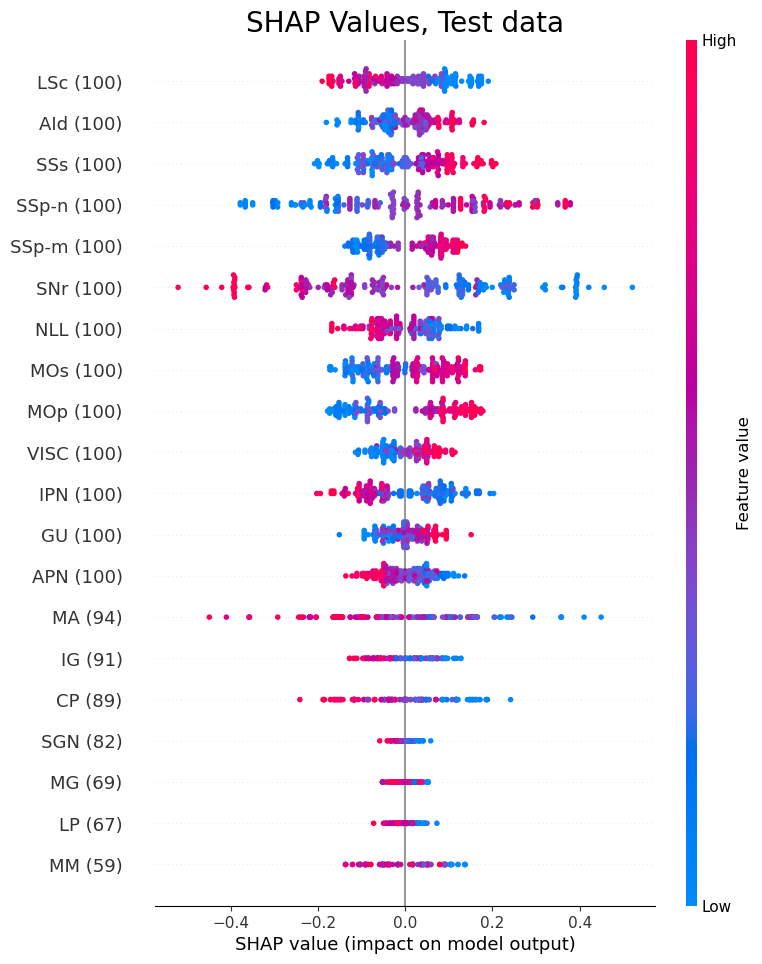

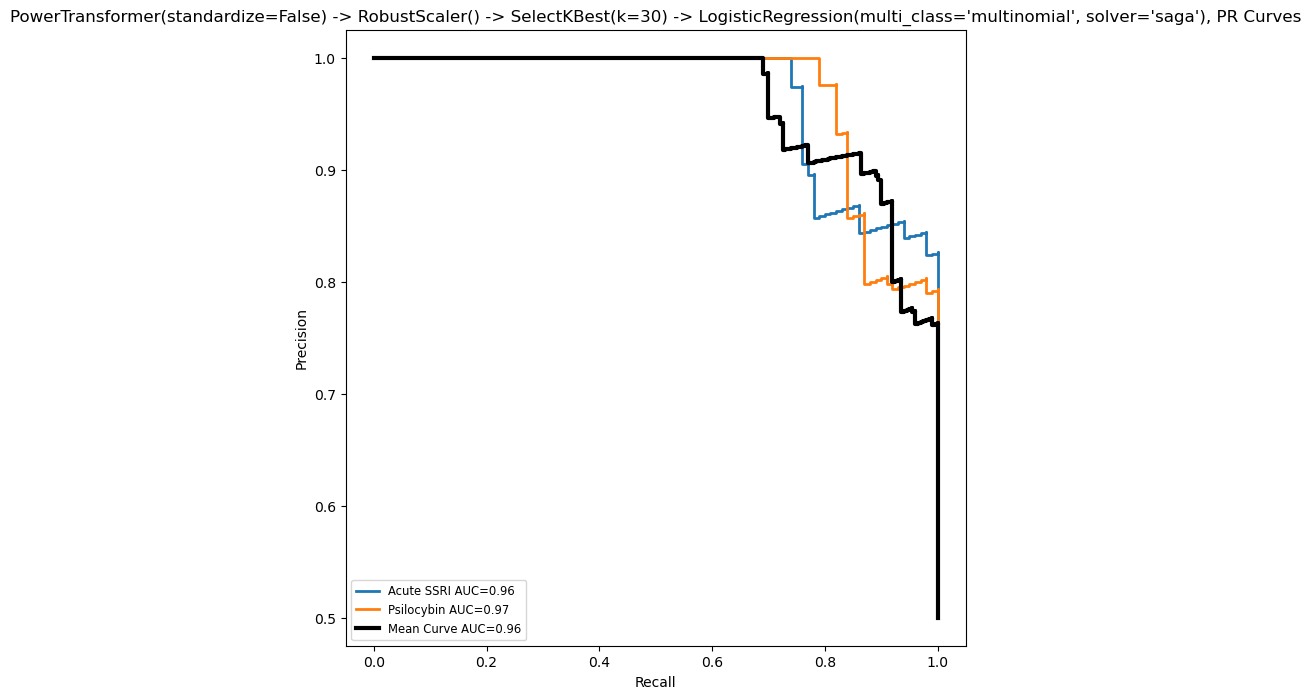

Real: 0.90 accuracy with a standard deviation of 0.20


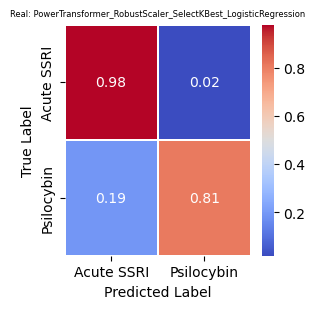

==== Acute SSRI vs Psilocybin ==== 
 Features per Model: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Parameters: 
 
Total Regions = 91 
 Present 1x: 6 - OT, ARH, POST, VTN, ORBm, MS
Present 2x: 1 - VISpl
Present 3x: 6 - NTB, LPO, CU, STN, PSTN, LDT
Present 4x: 5 - ACAd, PRM, AAA, PYR, LH
Present 5x: 2 - RL, CA1
Present 6x: 6 - MOB, AD, IAD, VTA, DTN, PMd
Present 7x: 3 - LD, NDB, SFO
Present 8x: 2 - VPM, AON
Present 9x: 3 - MD, FRP, AN
Present 10x: 3 - LSr, SBPV, SUB
Present 11x: 3 - MDRNv, SNc, TMd
Present 12x: 2 - SMT, NPC
Present 13x: 2 - PVi, DEC
Present 14x: 1 - RSPv
Present 15x: 2 - AV, CA3
Present 16x: 2 - ACAv, CUN
Present 19x: 

In [6]:
# classifyVec = ['drug', 'class_5HT2A', 'class_KetPsi', 'class_5HTR', 'class_Trypt', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI']
classifyVec = ['class_PsiSSRI']
classifyDict['model_featureSel'] = 'Boruta' # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'

for i in classifyVec:
    try:
        print(f"Classifying {i}")
        classifyDict['label'] = i
        classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)
    except:
      print(f"\n Failed to classify {i}")

# Rerun everything with 30 best features, as determined by univariate feature selection
classifyDict['model_featureSel'] = 'Univar' # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'
classifyDict['model_featureSel_k'] = [30]

for i in classifyVec:
    try:
        print(f"Classifying {i} with Univar")
        classifyDict['label'] = i
        classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)
    except:
      print(f"\n Failed to classify {i}")